<a href="https://colab.research.google.com/github/navi004/Deep-Learning-CSE4037-/blob/main/DL_Da2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digital Assignment - 2: Deep Learning
* **Name**: Naveen N  
* **Reg No**: 22MIA1049  
* **Topic**: Object Detection using YOLOv8 on Thermal Dogs and People Dataset


### 1. Install Required Libraries


In [ ]:
%%capture
!pip install ultralytics


In [ ]:
%%capture
!pip install roboflow

### 2. Import Essential Libraries


In [ ]:
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from ultralytics import YOLO
from IPython.display import Image as IPyImage, display


### 3. Import & Set Up API Key for Roboflow

In [ ]:
from google.colab import userdata
roboflow_api = userdata.get('Roboflow_api')

### 4. Download Dataset from Roboflow


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("joseph-nelson").project("thermal-dogs-and-people")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Thermal-Dogs-and-People-3 in yolov8:: 100%|██████████| 986/986 [00:00<00:00, 1478.15it/s]


### 5. Explore Dataset Structure


#### Check Dataset Folder Structure

In [ ]:
import os
base_path = dataset.location
base_dir = "/content/Thermal-Dogs-and-People-3"
for folder in ["train", "valid", "test"]:
    images_path = os.path.join(base_dir, folder, "images")
    labels_path = os.path.join(base_dir, folder, "labels")

    print(f"{folder.upper()}:")
    print(f"   - Images: {len(os.listdir(images_path))}")
    print(f"   - Labels: {len(os.listdir(labels_path))}")
    print("-" * 30)


TRAIN:
   - Images: 426
   - Labels: 426
------------------------------
VALID:
   - Images: 41
   - Labels: 41
------------------------------
TEST:
   - Images: 20
   - Labels: 20
------------------------------


#### Read and Display Classes

In [ ]:
import yaml

yaml_path = os.path.join(base_path, "data.yaml")

with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

print("Class names:")
for i, name in enumerate(data_yaml['names']):
    print(f"{i}: {name}")


Class names:
0: dog
1: person


#### Display Sample Images

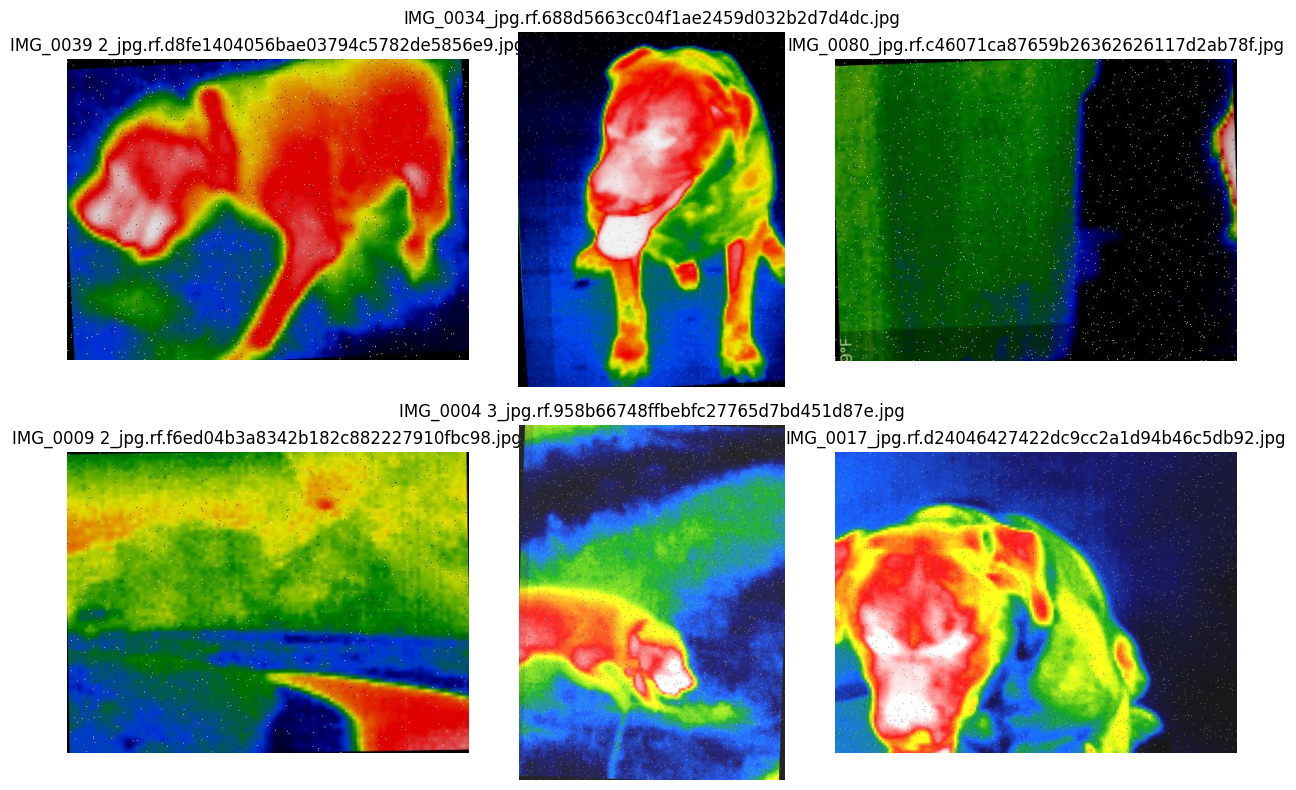

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2

sample_path = os.path.join(base_dir, "train", "images")
sample_images = os.listdir(sample_path)

# Randomly select 6 images from the dataset
random_images = random.sample(sample_images, 6)

# Create a figure for the random images
plt.figure(figsize=(12, 8))  # Increased size for better clarity
for i, img_name in enumerate(random_images):
    img = cv2.imread(os.path.join(sample_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color representation
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid of subplots
    plt.imshow(img)
    plt.title(img_name, fontsize=12)  # Set title with font size
    plt.axis('off')  # Hide axes
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### Check Image Shapes / Sizes

In [ ]:
import numpy as np

shapes = []
for img_name in sample_images[:10]:  # check first 10 images
    img = cv2.imread(os.path.join(sample_path, img_name))
    shapes.append(img.shape)

print("Sample Image Shapes:")
for i, shape in enumerate(shapes):
    print(f"{i+1}: {shape}")


Sample Image Shapes:
1: (296, 394, 3)
2: (406, 542, 3)
3: (482, 642, 3)
4: (542, 406, 3)
5: (570, 760, 3)
6: (328, 438, 3)
7: (610, 814, 3)
8: (524, 698, 3)
9: (784, 588, 3)
10: (320, 428, 3)


#### Analyze Image Dimensions

In [ ]:
from PIL import Image
import numpy as np

dims = []

image_folder = os.path.join(base_path, 'train', 'images')
for img_file in os.listdir(image_folder)[:200]:  # Sample 200 for speed
    img_path = os.path.join(image_folder, img_file)
    with Image.open(img_path) as img:
        dims.append(img.size)

dims = np.array(dims)
print(f"Average Image Size: {np.mean(dims, axis=0).astype(int)} (W x H)")
print(f"Max Image Size: {np.max(dims, axis=0)}")
print(f"Min Image Size: {np.min(dims, axis=0)}")


Average Image Size: [559 533] (W x H)
Max Image Size: [820 820]
Min Image Size: [268 268]


### 6. Class Distribution

Classes in dataset: ['dog', 'person']


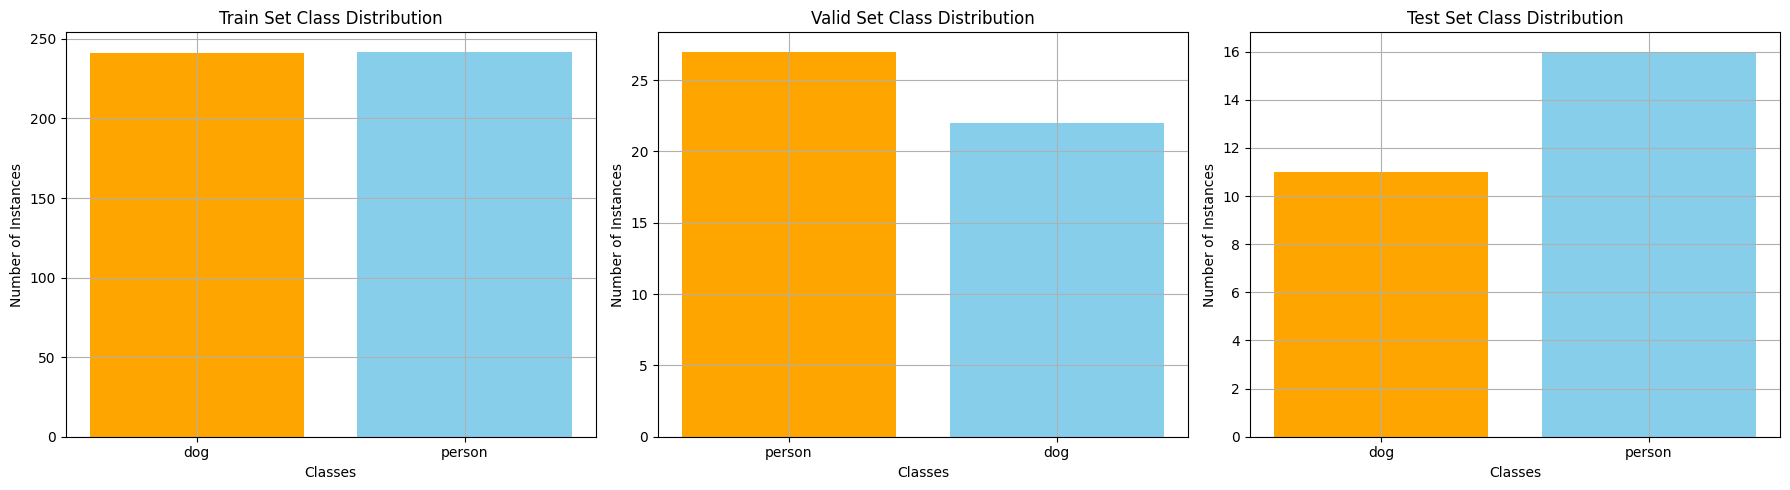

In [ ]:
import os
import yaml
import matplotlib.pyplot as plt
from collections import defaultdict

# Load data.yaml to get class names
with open(os.path.join(base_path, "data.yaml"), "r") as f:
    data_config = yaml.safe_load(f)
class_names = data_config['names']
print("Classes in dataset:", class_names)

# Function to count labels in YOLO format text files
def count_labels_in_folder(label_folder):
    label_counts = defaultdict(int)
    for label_file in os.listdir(label_folder):
        if label_file.endswith(".txt"):
            with open(os.path.join(label_folder, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    label_counts[class_id] += 1
    return label_counts

# Folders
label_folders = {
    "train": os.path.join(base_path, "train", "labels"),
    "valid": os.path.join(base_path, "valid", "labels"),
    "test": os.path.join(base_path, "test", "labels")
}

# Count all
all_counts = {split: count_labels_in_folder(path) for split, path in label_folders.items()}

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (split, counts) in enumerate(all_counts.items()):
    axs[i].bar(
        [class_names[c] for c in counts.keys()],
        [counts[c] for c in counts.keys()],
        color=["orange", "skyblue"]
    )
    axs[i].set_title(f"{split.capitalize()} Set Class Distribution")
    axs[i].set_ylabel("Number of Instances")
    axs[i].set_xlabel("Classes")
    axs[i].grid(True)

plt.tight_layout()
plt.show()


### 7. YOLOv8 Fine-Tuning on "Thermal Dogs and People

#### Import & Load the YOLOv8 Model

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8n model (nano version)
model = YOLO("yolov8n.pt")


100%|██████████| 6.25M/6.25M [00:00<00:00, 98.8MB/s]


#### Fine-Tune the Model

In [ ]:
# Train the model
model.train(
    data=os.path.join(base_path, "data.yaml"),
    epochs=25,
    imgsz=640,
    batch=16,
    project="thermal-dog-people",  # Where results will be saved
    name="yolov8n-custom",
    exist_ok=True
)


Ultralytics 8.3.106 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Thermal-Dogs-and-People-3/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=thermal-dog-people, name=yolov8n-custom, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.5MB/s]


AMP: checks passed ✅


train: Scanning /content/Thermal-Dogs-and-People-3/train/labels... 426 images, 58 backgrounds, 0 corrupt: 100%|██████████| 426/426 [00:00<00:00, 2710.57it/s]

train: New cache created: /content/Thermal-Dogs-and-People-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Thermal-Dogs-and-People-3/valid/labels... 41 images, 5 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 4010.13it/s]

val: New cache created: /content/Thermal-Dogs-and-People-3/valid/labels.cache


Plotting labels to thermal-dog-people/yolov8n-custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to thermal-dog-people/yolov8n-custom
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.14G      1.092      2.668      1.419         26        640: 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         41         49    0.00293      0.747      0.323      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.62G      1.013      1.936      1.346         26        640: 100%|██████████| 27/27 [00:07<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         41         49       0.54      0.226      0.296      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.63G      1.025      1.777      1.339         24        640: 100%|██████████| 27/27 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         41         49      0.422      0.184        0.2      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.65G      1.052      1.738      1.372         25        640: 100%|██████████| 27/27 [00:07<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         41         49      0.766      0.324      0.542      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.67G      1.074      1.627      1.398         25        640: 100%|██████████| 27/27 [00:06<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         41         49      0.653      0.467      0.553      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.69G      1.065      1.578      1.384         25        640: 100%|██████████| 27/27 [00:07<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


                   all         41         49      0.853      0.735      0.846      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       2.7G     0.9959      1.396       1.32         27        640: 100%|██████████| 27/27 [00:07<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         41         49      0.831      0.761      0.796      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.72G     0.9837      1.389      1.323         26        640: 100%|██████████| 27/27 [00:06<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         41         49      0.803       0.75      0.845      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.74G     0.9158      1.236      1.252         25        640: 100%|██████████| 27/27 [00:07<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


                   all         41         49      0.666      0.771      0.704      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.76G     0.9064      1.191      1.267         14        640: 100%|██████████| 27/27 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         41         49       0.89      0.903      0.947      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.76G     0.8725      1.136      1.219         28        640: 100%|██████████| 27/27 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


                   all         41         49      0.896      0.841      0.922       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.79G     0.8511      1.083      1.233         22        640: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         41         49      0.939       0.85      0.957      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.81G     0.8864      1.151      1.262         33        640: 100%|██████████| 27/27 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         41         49       0.92      0.827      0.914       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.82G     0.8529      1.018      1.229         22        640: 100%|██████████| 27/27 [00:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


                   all         41         49       0.94       0.88      0.962      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.83G     0.8355     0.9913      1.224         22        640: 100%|██████████| 27/27 [00:07<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


                   all         41         49      0.938      0.938       0.98      0.715
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.86G     0.8179      1.051      1.225         12        640: 100%|██████████| 27/27 [00:07<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         41         49      0.989      0.889      0.968      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.88G     0.7685     0.9028      1.185          8        640: 100%|██████████| 27/27 [00:06<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         41         49      0.963      0.951      0.982      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.89G     0.7887     0.8644      1.191         12        640: 100%|██████████| 27/27 [00:06<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         41         49      0.986      0.871      0.975      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       2.9G     0.7235      0.828      1.159          9        640: 100%|██████████| 27/27 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         41         49      0.965      0.922      0.974      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.93G     0.7148      0.748      1.135         11        640: 100%|██████████| 27/27 [00:07<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         41         49      0.947      0.922      0.963      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.94G     0.6742     0.7244      1.106         11        640: 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         41         49      0.995      0.898      0.968      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.96G     0.6584     0.6801      1.098          8        640: 100%|██████████| 27/27 [00:07<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         41         49      0.993      0.885       0.96      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.97G     0.6474     0.6866      1.085         13        640: 100%|██████████| 27/27 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         41         49       0.99      0.885       0.96      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.99G     0.5916     0.6149      1.052         12        640: 100%|██████████| 27/27 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         41         49      0.993      0.885      0.958      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.01G     0.5617      0.603      1.046         11        640: 100%|██████████| 27/27 [00:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


                   all         41         49      0.993      0.883      0.967      0.725

25 epochs completed in 0.057 hours.
Optimizer stripped from thermal-dog-people/yolov8n-custom/weights/last.pt, 6.2MB
Optimizer stripped from thermal-dog-people/yolov8n-custom/weights/best.pt, 6.2MB

Validating thermal-dog-people/yolov8n-custom/weights/best.pt...
Ultralytics 8.3.106 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


                   all         41         49      0.995      0.898      0.968      0.728
                   dog         22         22       0.99      0.955      0.986      0.803
                person         19         27          1      0.842      0.949      0.653
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to thermal-dog-people/yolov8n-custom


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e955f678290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

#### Training Metrics

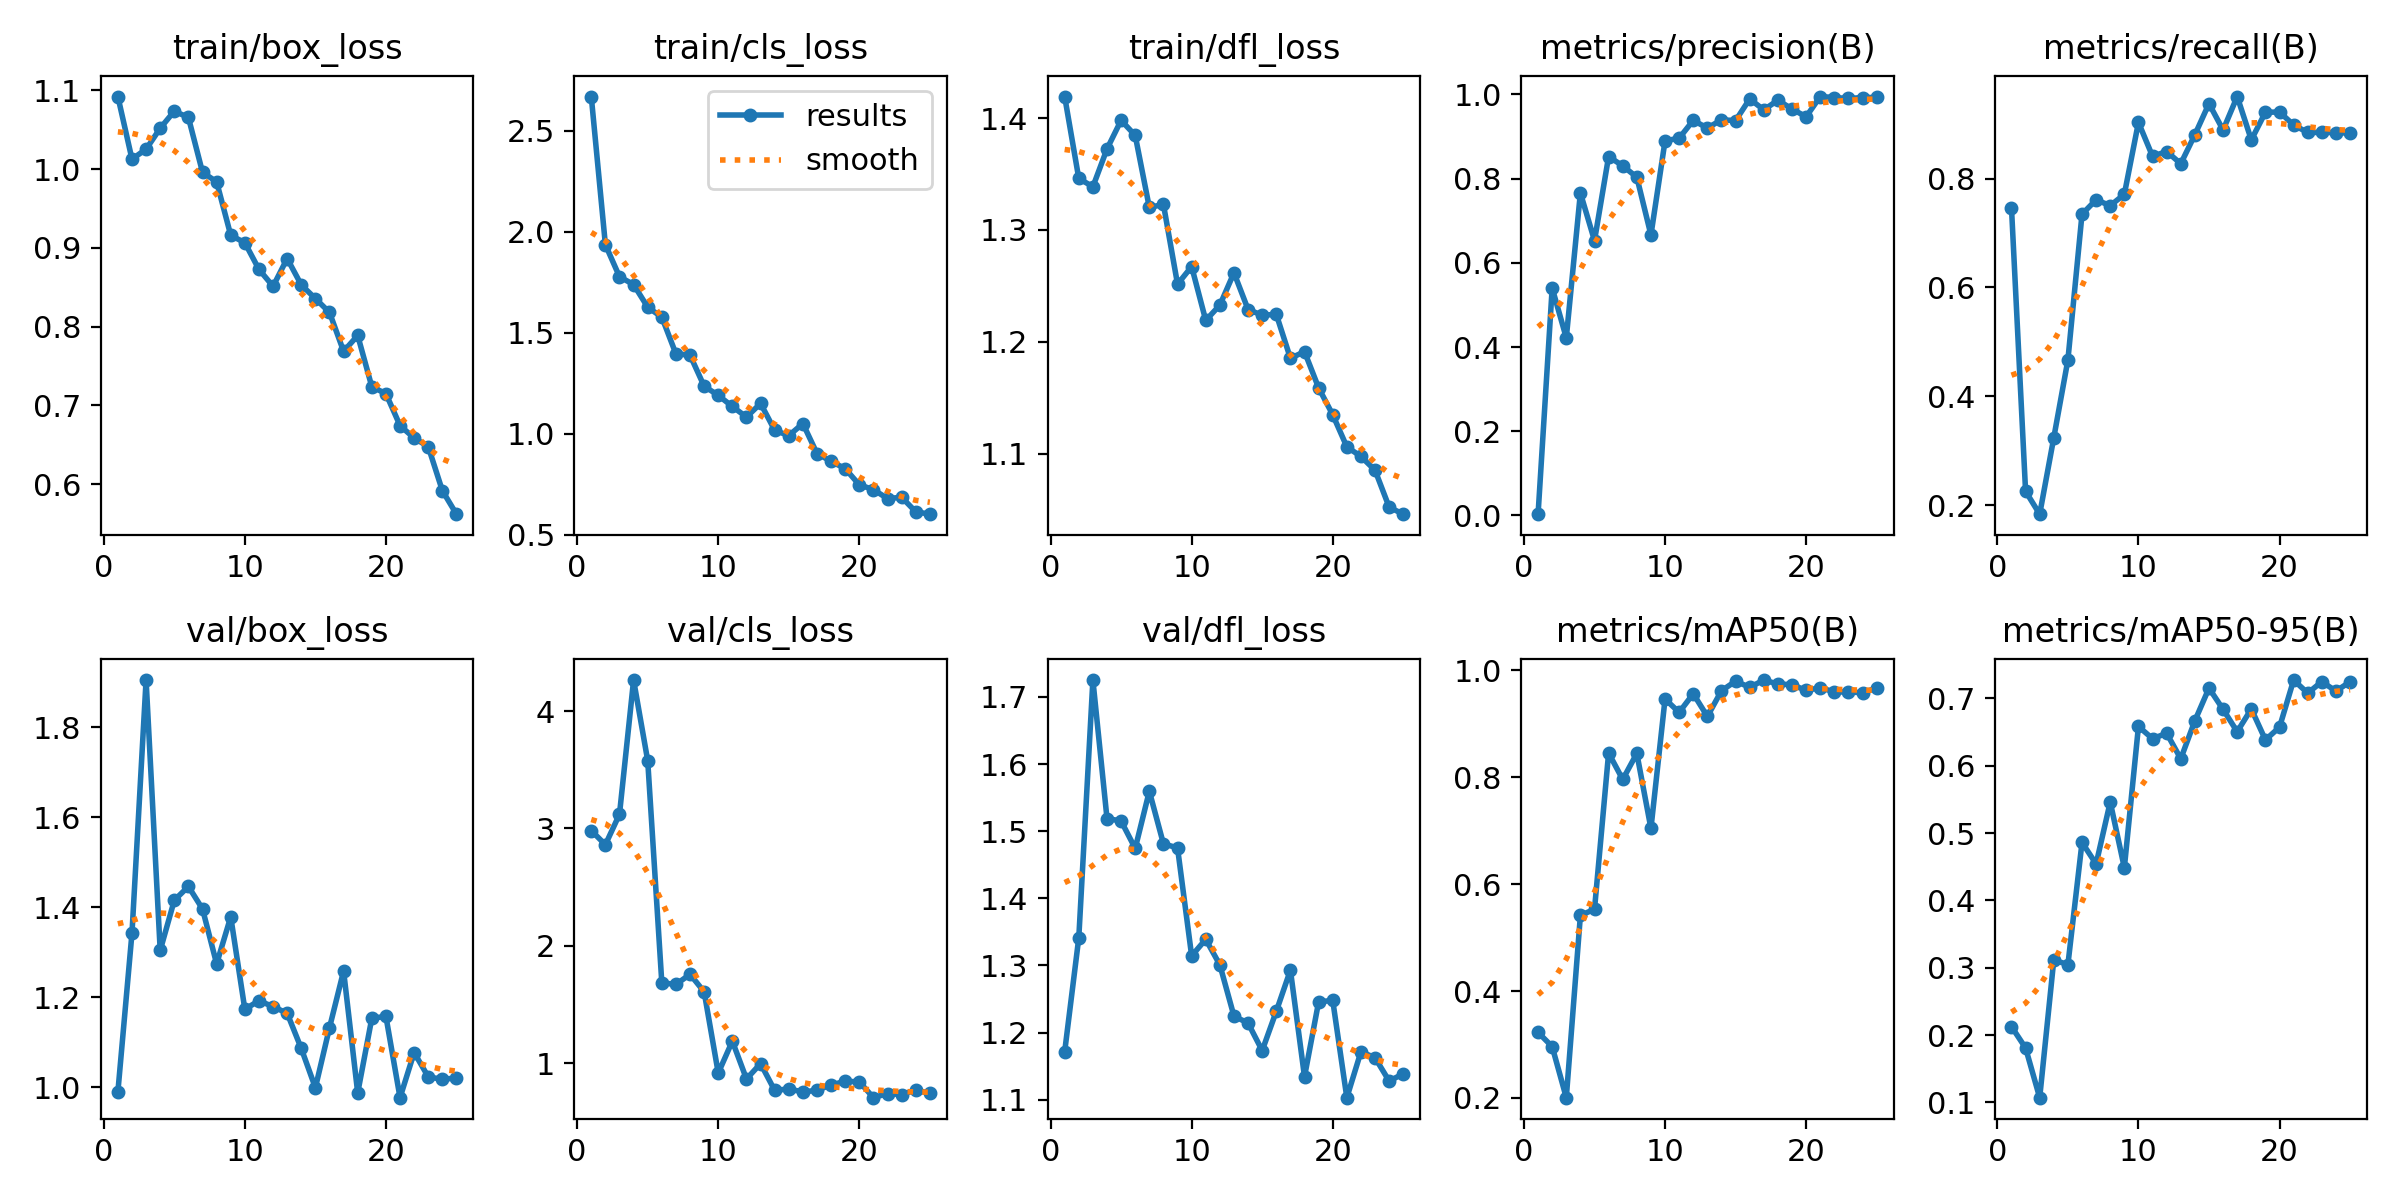

In [ ]:
from IPython.display import Image, display

# Display training results
display(Image(filename='thermal-dog-people/yolov8n-custom/results.png'))


#### Evaluate Model on Test Set

In [ ]:
# Evaluate on test set
metrics = model.val(split='test')
print(metrics)


Ultralytics 8.3.106 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Thermal-Dogs-and-People-3/test/labels... 20 images, 2 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 3046.08it/s]

val: New cache created: /content/Thermal-Dogs-and-People-3/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


                   all         20         27      0.984      0.951      0.974      0.732
                   dog         11         11          1      0.902      0.952      0.736
                person         11         16      0.969          1      0.995      0.727
Speed: 8.9ms preprocess, 11.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to thermal-dog-people/yolov8n-custom
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e955e9fbc50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018, 

In [ ]:
# Access class-wise metrics
precision_per_class = metrics.box.p
recall_per_class    = metrics.box.r
map50_per_class     = metrics.box.ap50
map_per_class       = metrics.box.ap

# Class names (from model.yaml or training config)
class_names = model.names

# Display mean values
print("YOLOv8 Evaluation Metrics (Average Across Classes)")
print(f"Precision (mean): {sum(precision_per_class) / len(precision_per_class):.4f}")
print(f"Recall (mean)   : {sum(recall_per_class) / len(recall_per_class):.4f}")
print(f"mAP@0.5 (mean)  : {sum(map50_per_class) / len(map50_per_class):.4f}")
print(f"mAP@0.5:0.95    : {sum(map_per_class) / len(map_per_class):.4f}")

# Show per-class metrics
print("\nPer-Class Metrics:")
for i, name in class_names.items():
    print(f" - {name}: Precision={precision_per_class[i]:.3f}, Recall={recall_per_class[i]:.3f}, mAP50={map50_per_class[i]:.3f}, mAP50-95={map_per_class[i]:.3f}")


YOLOv8 Evaluation Metrics (Average Across Classes)
Precision (mean): 0.9843
Recall (mean)   : 0.9511
mAP@0.5 (mean)  : 0.9736
mAP@0.5:0.95    : 0.7319

Per-Class Metrics:
 - dog: Precision=1.000, Recall=0.902, mAP50=0.952, mAP50-95=0.736
 - person: Precision=0.969, Recall=1.000, mAP50=0.995, mAP50-95=0.727


#### Confusion Matrix

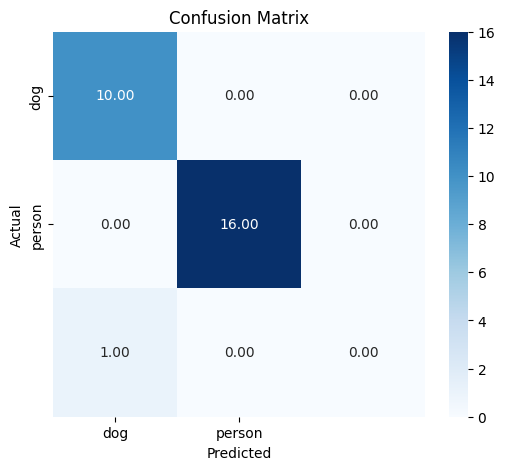

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
if hasattr(metrics, "confusion_matrix") and metrics.confusion_matrix is not None:
    cm = metrics.confusion_matrix.matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


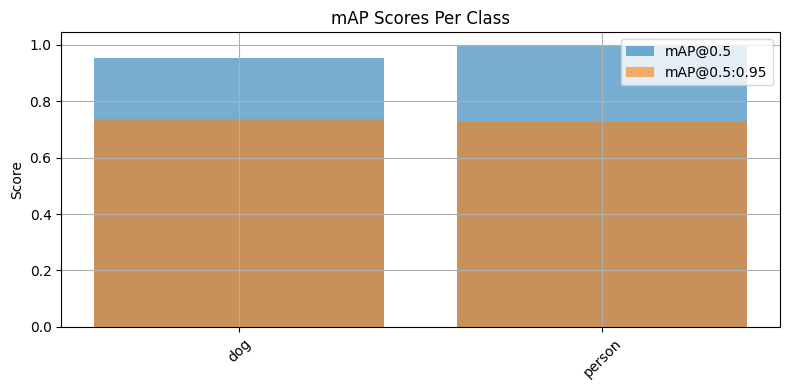

In [ ]:
import matplotlib.pyplot as plt

# Bar chart for mAP50 and mAP50-95 per class
plt.figure(figsize=(8, 4))
x = list(class_names.values())

plt.bar(x, map50_per_class, alpha=0.6, label="mAP@0.5")
plt.bar(x, map_per_class, alpha=0.6, label="mAP@0.5:0.95")

plt.ylabel("Score")
plt.title("mAP Scores Per Class")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Output visualization


image 1/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0002 4_jpg.rf.4c2b958cb5cee437006841da59b83a13.jpg: 640x480 2 persons, 23.9ms
image 2/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0006 5_jpg.rf.adf2bfa382f8a74dbdbb8e0f74943446.jpg: 480x640 1 dog, 1 person, 13.9ms
image 3/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0009_jpg.rf.a61c671b45ce694c49102cf3f5e2ca88.jpg: 480x640 1 dog, 14.0ms
image 4/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0012 2_jpg.rf.4ca8a689998d972d80261a18b780929e.jpg: 480x640 2 persons, 13.4ms
image 5/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0022_jpg.rf.b4ce491868042c1f1169cf68dbc31b83.jpg: 480x640 1 dog, 13.8ms
image 6/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0023 3_jpg.rf.be718f521f7a84361f44506613686fab.jpg: 640x480 1 dog, 1 person, 12.8ms
image 7/20 /content/Thermal-Dogs-and-People-3/test/images/IMG_0024 2_jpg.rf.293d99b0cf87f0964a19eac4c9249b4f.jpg: 640x480 2 persons, 13.4ms
image 8/20 /content

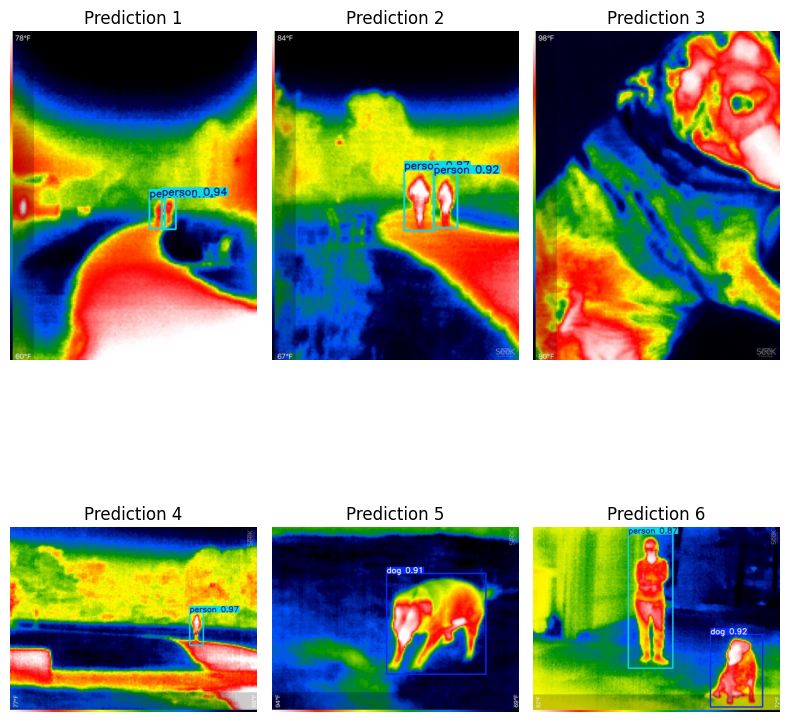

In [ ]:
from glob import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

# Predict on your test images folder
test_imgs_dir = "/content/Thermal-Dogs-and-People-3/test/images"
results = model.predict(source=test_imgs_dir, save=True, conf=0.25)

# Get predicted images from the default output folder
pred_path = "runs/detect/predict"
pred_imgs = glob(os.path.join(pred_path, "*.jpg"))

# Display predictions in a grid
num_images = min(6, len(pred_imgs))  # Show up to 6
cols = 3
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(8, 5 * rows))
for i in range(num_images):
    img = mpimg.imread(pred_imgs[i])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction {i + 1}", fontsize=12)

plt.tight_layout()
plt.show()
